# Importing packages and files

In [1]:
import json

import graphviz
import requests
from IPython.display import display
from anytree.exporter import DotExporter

URL = "127.0.0.1"
PORT = 8001

In [2]:
with open("bpmn_test_api.json", "r") as f:
    bpmn_file = f.read()

bpmn = json.loads(bpmn_file)

# Initialize petri net and execution tree

In [3]:
request_json = {
    "bpmn": bpmn
}

response = requests.post(f"http://{URL}:{PORT}/execute", headers={"Content-Type": "application/json"},
                         json=request_json)
response_json = response.json()

In [4]:
bpmn = response_json['bpmn']
petri_net = response_json['petri_net']
petri_net_dot = response_json['petri_net_dot']
execution_tree = response_json['execution_tree']

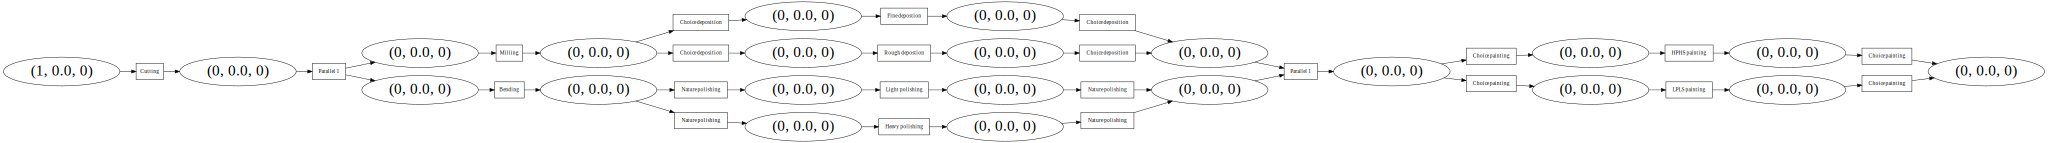

In [5]:
graph = graphviz.Source(petri_net_dot, format="svg")
display(graph)

# Execute choice

In [ ]:
request_json = {
    'bpmn': bpmn,
    'petri_net': petri_net,
    'petri_net_dot': petri_net_dot,
    'execution_tree': execution_tree,
    # 'choices': ['6'] # id delle transizioni con stop da eseguire, se non vengono passati vengono presi i default
}

response = requests.post(f"http://{URL}:{PORT}/execute", headers={"Content-Type": "application/json"},
                         json=request_json)
response_json = response.json()

In [ ]:
bpmn = response_json['bpmn']
petri_net = response_json['petri_net']
petri_net_dot = response_json['petri_net_dot']
execution_tree = response_json['execution_tree']

In [ ]:
graph = graphviz.Source(petri_net_dot, format="svg")
display(graph)

In [ ]:
from model.endpoints.execute.request import ExecuteRequest

model = ExecuteRequest.model_validate_json(response.text)
extree = model.execution_tree_obj
extree_dot = "\n".join(DotExporter(extree.root))
display(graphviz.Source(extree_dot))

# Steps Test

In [ ]:
request_json = {
    'bpmn': bpmn,
    'petri_net': petri_net,
    'petri_net_dot': petri_net_dot,
    'execution_tree': execution_tree,
    # 'choices': ['6'] # id delle transizioni con stop da eseguire, se non vengono passati vengono presi i default
}

response = requests.post(f"http://{URL}:{PORT}/steps", headers={"Content-Type": "application/json"}, json=request_json)
response_json = response.json()

In [ ]:
response_json

In [ ]:
graph = graphviz.Source(petri_net_dot, format="svg")
display(graph)

# Display BPMN

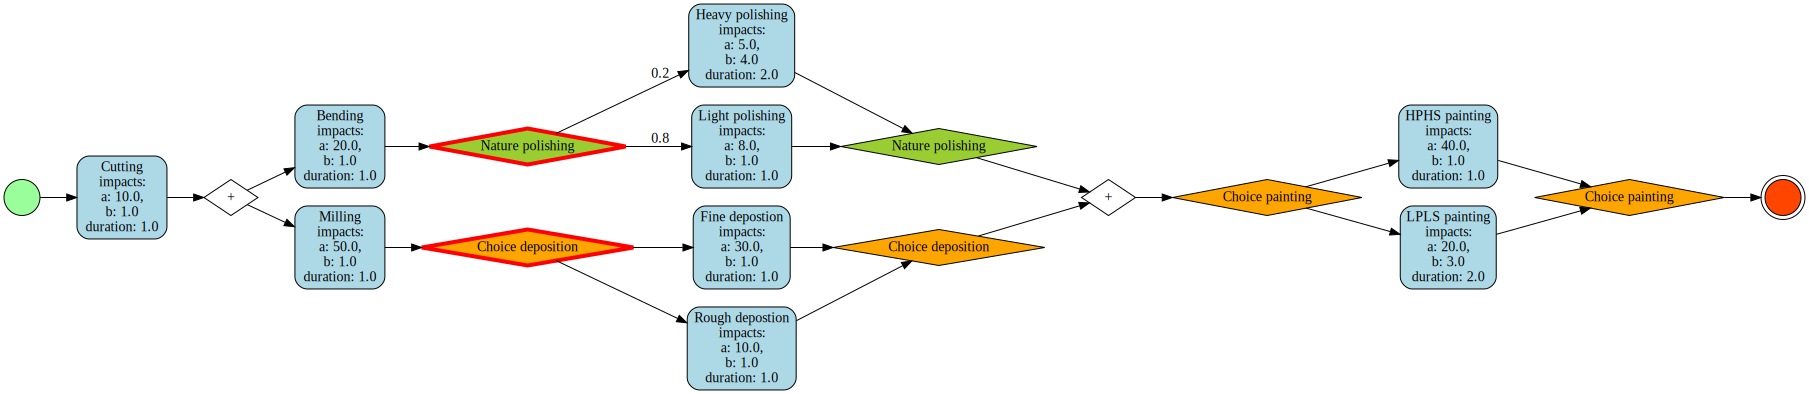

In [12]:
ACTIVE_BORDER_COLOR = "red"
ACTIVE_BORDER_WIDTH = 4
ACTIVE_STYLE = "solid"


def node_to_dot(_id, shape, label, style, fillcolor, border_color=None, border_size=None):
    other_code = ""
    if border_color is not None:
        other_code += f'color={border_color} '
    if border_size is not None:
        other_code += f'penwidth={border_size} '
    return f'\nnode_{_id}[shape={shape} label="{label or ""}" style="{style or ""}" fillcolor={fillcolor} {other_code or ""}];'


def gateway_to_dot(_id, label, style, fillcolor, border_color=None, border_size=None):
    return node_to_dot(_id, "diamond", label, style, fillcolor, border_color, border_size)


def exclusive_gateway_to_dot(_id, label, style, border_color=None, border_size=None):
    if style is None:
        style = "filled"
    else:
        style = f"filled,{style}"
    return gateway_to_dot(_id, label, style, "orange", border_color, border_size)


def parallel_gateway_to_dot(_id, style, border_color=None, border_size=None):
    return gateway_to_dot(_id, f"+", style, "green", border_color, border_size)


def probabilistic_gateway_to_dot(_id, name, style, border_color=None, border_size=None):
    if style is None:
        style = "filled"
    else:
        style = f"filled,{style}"
    return gateway_to_dot(_id, f"{name}", style, "yellowgreen", border_color, border_size)


def loop_gateway_to_dot(_id, label, style, border_color=None, border_size=None):
    if style is None:
        style = "filled"
    else:
        style = f"filled,{style}"
    return gateway_to_dot(_id, label, style, "yellowgreen", border_color, border_size)


def task_to_dot(_id, name, style, impacts, duration, impacts_names, border_color=None, border_size=None):
    additional_label = ""
    if impacts:
        tmp = ", ".join(f"\\n{key}: {value}" for key, value in zip(impacts_names, impacts))
        additional_label += f"\\n impacts: {tmp}"
    if duration:
        additional_label += f"\\n duration: {duration}"

    if style is None:
        style = "rounded,filled"
    else:
        style = f"rounded,filled,{style}"

    return node_to_dot(
        _id,
        "rectangle",
        f"{name}{additional_label}",
        style,
        "lightblue",
        border_color,
        border_size
    )


def arc_to_dot(from_id, to_id, label=None):
    if label is None:
        return f'\nnode_{from_id} -> node_{to_id};\n'
    else:
        return f'\nnode_{from_id} -> node_{to_id}[label="{label}"];\n'


def wrap_to_dot(region_root, impacts_names, active_regions=None):
    code = "digraph G {\n"
    code += "rankdir=LR;\n"
    code += 'start[label="" style="filled" shape=circle fillcolor=palegreen1]\n'
    code += 'end[label="" style="filled" shape=doublecircle fillcolor=orangered] \n'
    other_code, entry_id, exit_id = region_to_dot(region_root, impacts_names, active_regions)
    code += other_code
    code += f'start -> node_{entry_id};\n'
    code += f'node_{exit_id} -> end;\n'
    code += "\n}"

    return code


def serial_generator():
    """Generator to create unique IDs."""
    id_counter = 0
    while True:
        yield id_counter
        id_counter += 1


id_generator = serial_generator()


def region_to_dot(region_root, impacts_names, active_regions):
    is_active = region_root.get('id') in active_regions
    if region_root.get("type") == 'task':
        _id = next(id_generator)
        return task_to_dot(
            _id,
            region_root.get('label'),
            ACTIVE_STYLE if is_active else None,
            region_root.get('impacts', []),
            region_root.get('duration'),
            impacts_names,
            border_color=ACTIVE_BORDER_COLOR if is_active else None,
            border_size=ACTIVE_BORDER_WIDTH if is_active else None
        ), _id, _id
    elif region_root.get("type") == 'loop':
        entry_id = next(id_generator)
        ext_id = next(id_generator)

        # Entry point
        code = loop_gateway_to_dot(
            entry_id,
            region_root.get('label'),
            style=None,
            border_color=ACTIVE_BORDER_COLOR if is_active else None,
            border_size=ACTIVE_BORDER_WIDTH if is_active else None
        )

        # Exit point
        code += loop_gateway_to_dot(
            ext_id,
            region_root.get('label'),
            region_root.get('style')
        )

        # Child
        other_code, child_entry_id, child_exit_id = region_to_dot(region_root.get('children')[0], impacts_names,
                                                                  active_regions)
        code += other_code
        p = region_root.get('distribution')
        code += arc_to_dot(entry_id, child_entry_id, p)
        code += arc_to_dot(child_exit_id, ext_id, 1 - p)

        return code, entry_id, ext_id
    elif region_root.get("type") == 'choice':
        entry_id = next(id_generator)
        last_exit_id = next(id_generator)

        # Entry point
        code = exclusive_gateway_to_dot(
            entry_id,
            region_root.get('label'),
            ACTIVE_STYLE if is_active else None,
            border_color=ACTIVE_BORDER_COLOR if is_active else None,
            border_size=ACTIVE_BORDER_WIDTH if is_active else None
        )

        # Exit point
        code += exclusive_gateway_to_dot(
            last_exit_id,
            region_root.get('label'),
            style=None
        )

        # Children
        for child in region_root.get('children', []):
            child_code, child_entry_id, child_exit_id = region_to_dot(child, impacts_names, active_regions)
            code += child_code
            code += arc_to_dot(entry_id, child_entry_id)
            code += arc_to_dot(child_exit_id, last_exit_id)

        return code, entry_id, last_exit_id
    elif region_root.get("type") == 'parallel':
        entry_id = next(id_generator)
        last_exit_id = next(id_generator)

        # Entry point
        code = parallel_gateway_to_dot(
            entry_id,
            style=ACTIVE_STYLE if is_active else None,
            border_color=ACTIVE_BORDER_COLOR if is_active else None,
            border_size=ACTIVE_BORDER_WIDTH if is_active else None
        )

        # Exit point
        code += parallel_gateway_to_dot(
            last_exit_id,
            style=None
        )

        # Children
        for child in region_root.get('children', []):
            child_code, child_entry_id, child_exit_id = region_to_dot(child, impacts_names, active_regions)
            code += child_code
            code += arc_to_dot(entry_id, child_entry_id)
            code += arc_to_dot(child_exit_id, last_exit_id)

        return code, entry_id, last_exit_id
    elif region_root.get("type") == 'nature':
        entry_id = next(id_generator)
        last_exit_id = next(id_generator)

        # Entry point
        code = probabilistic_gateway_to_dot(
            entry_id,
            region_root.get('label'),
            style=ACTIVE_STYLE if is_active else None,
            border_color=ACTIVE_BORDER_COLOR if is_active else None,
            border_size=ACTIVE_BORDER_WIDTH if is_active else None
        )

        # Exit point
        code += probabilistic_gateway_to_dot(
            last_exit_id,
            region_root.get('label'),
            style=None
        )

        # Children
        for child, p in zip(region_root.get('children', []), region_root.get("distribution", [])):
            child_code, child_entry_id, child_exit_id = region_to_dot(child, impacts_names, active_regions)
            code += child_code
            code += arc_to_dot(entry_id, child_entry_id, p)
            code += arc_to_dot(child_exit_id, last_exit_id)

        return code, entry_id, last_exit_id
    elif region_root.get("type") == 'sequential':
        code = ""
        entry_id = None
        last_exit_id = None

        for i, child in enumerate(region_root.get('children', [])):
            child_code, child_entry_id, child_exit_id = region_to_dot(child, impacts_names, active_regions)
            code += child_code

            arc = arc_to_dot(last_exit_id, child_entry_id) if last_exit_id is not None else ""
            if entry_id is None:
                entry_id = child_entry_id
                arc = ""

            last_exit_id = child_exit_id
            code += arc

        return code, entry_id, last_exit_id
    else:
        raise ValueError(f"Unknown type: {region_root['type']}")


def get_active_region_by_pn(petri_net, marking):
    active_regions = set()

    for place in petri_net.get("places", []):
        place_id = place["id"]
        entry_region_id = place.get("entry_region_id")
        place_state = marking.get(place_id, {"token": 0})
        if entry_region_id and place_state['token'] > 0:
            active_regions.add(entry_region_id)

    return active_regions


impacts_names = ["a", "b"]
marking = {"21": {"token": 1}, "7": {"token": 1}}

active_region_by_pn = get_active_region_by_pn(petri_net, marking)
dot = wrap_to_dot(bpmn, impacts_names, active_region_by_pn)
graph = graphviz.Source(dot, format="svg")

display(graph)

# Display Execution Tree

In [ ]:
ACTIVE_NODE_COLOR = "ffa500"        # Orange
INACTIVE_NODE_COLOR = "808080"      # Grey
TEXT_COLOR = "000000"               # Black
ALPHA_ACTIVE_BACKGROUND = "ff"      # Full opacity for visible nodes
ALPHA_ACTIVE_TEXT = "ff"            # Full opacity for visible nodes
ALPHA_INACTIVE_BACKGROUND = "7f"    # Semi-transparent for inactive nodes
ALPHA_INACTIVE_TEXT = "7f"          # Semi-transparent for inactive nodes

def node_to_dot(_id, p, impacts, execution_time, impacts_name=None, visible=True):
    if impacts_name is None or len(impacts_name) == 0:
        impacts_name = [i+1 for i in range(len(impacts))]

    bg_color = ACTIVE_NODE_COLOR if visible else INACTIVE_NODE_COLOR  # Use active color if visible, inactive if not
    alpha_bg = ALPHA_ACTIVE_BACKGROUND if visible else ALPHA_INACTIVE_BACKGROUND  # Full opacity if visible, semi-transparent if not
    alpha_text = ALPHA_ACTIVE_TEXT if visible else ALPHA_INACTIVE_TEXT  # Full opacity if visible, semi-transparent if not
    impacts_label = f"[{", ".join([f"{name}: {value}" for name, value in zip(impacts_name, impacts)])}]"
    return f'\nnode_{_id}[shape=oval label="ID: {_id}\\nProbability: {p}\\nImpacts:\\n{impacts_label}\\nExecution time: {execution_time}" style="filled" fillcolor="#{bg_color}{alpha_bg}" fontcolor="#{TEXT_COLOR}{alpha_text}"];'

def tree_to_dot(tree_root, impacts_names, path=None):
    """
    Render the execution tree as a dot representation.
    :param tree_root: Root of the execution tree
    :param impacts_names: Impacts names to display
    :param path: Ids of the nodes in the path to highlight
    :return: Dot representation of the execution tree
    """
    if path is None:
        path = []

    def apply(root):
        code = ""
        is_active = root.get('id') in path

        node_id = root.get('id')
        snapshot = root.get('snapshot', {})
        p = snapshot.get('p', 1.0)
        impacts = snapshot.get('impacts', [0 for _ in impacts_names])
        execution_time = snapshot.get('execution_time', 0)

        code += node_to_dot(
            node_id,
            p,
            impacts,
            execution_time,
            impacts_name=impacts_names,
            visible=is_active
        )

        for child in root.get("children", []):
            child_code = apply(child)
            code += child_code
            code += f'\nnode_{root.get("id")} -> node_{child.get("id")};\n'

        return code

    return apply(tree_root)

def wrapper_execution_tree_to_dot(tree_root, impacts_names, path=None):
    """
    Wrapper to create the dot representation of the execution tree.
    :param tree_root: Execution tree object
    :param impacts_names: Impacts names to display
    :param path: Ids of the nodes in the path to highlight
    :return: Dot representation of the execution tree
    """
    code = "digraph G {\n"
    code += tree_to_dot(tree_root, impacts_names, path)
    code += "\n}"

    return code

def get_path_to_current_node(tree_root, current_node_id):
    """
    Get the path to the current node in the execution tree.
    :param tree_root: Root of the execution tree
    :param current_node_id: ID of the current node
    :return: List of node IDs in the path to the current node
    """
    if tree_root.get('id') == current_node_id:
        return [current_node_id]

    for child in tree_root.get("children", []):
        path = get_path_to_current_node(child, current_node_id)
        if path is not None:
            return [tree_root.get('id')] + path

    return None

current_path = get_path_to_current_node(execution_tree.get("root",{}), execution_tree.get("current_node"))
dot = wrapper_execution_tree_to_dot(execution_tree.get("root", {}), impacts_names, current_path)
graph = graphviz.Source(dot, format="svg")
display(graph)